In [44]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()

In [46]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [47]:
block_size = 3
vocab_size = len(chars)

In [48]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [130]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 useless because of batch norm's layer own bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros(n_hidden)
bnstd_running = torch.zeros(n_hidden)
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [124]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 removing b1 because bn layer will have its own # hidden layer pre-activation 
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad(): # keeo the running stats
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


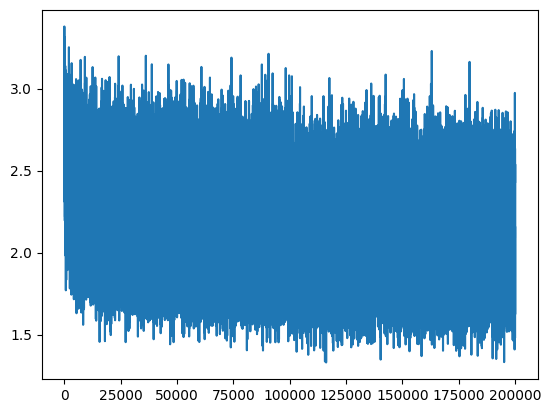

In [125]:
plt.plot(lossi)


In [126]:
with torch.no_grad():
    emb = C[Xtr]
    x = emb.view(emb.shape[0], -1)
    hpreact = x @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [127]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0865,  1.0937,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6116,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8355,
         -0.0854, -0.5177, -0.3806, -1.0699, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4523,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0111,  2.1495, -0.6393,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2112, -0.3226,  

In [128]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9001,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0699, -0.0780,  0.3370, -0.5768,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6768,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [129]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


When 
```
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```
<pre>
      
      0/ 200000: 27.8817 <------- this is way to high, means the initialization is wrong. you sholud have a roiugh idea of what the initial loss should be. The network is very confidentl wrog
  10000/ 200000: 2.8547  <- at init the distribvutoin should be uniform. p=1/27, nll = -log(1/27) = 3.29. this should be roughly the starting point. the initial logits should be roughly the same for all chars
  20000/ 200000: 2.5158
  30000/ 200000: 2.8251
  40000/ 200000: 2.0468
  50000/ 200000: 2.5537
  60000/ 200000: 2.3718
  70000/ 200000: 2.1337
  80000/ 200000: 2.2612
  90000/ 200000: 2.3405
 100000/ 200000: 2.0309
 110000/ 200000: 2.4856
 120000/ 200000: 1.9046
 130000/ 200000: 2.4561
 140000/ 200000: 2.2440
 150000/ 200000: 2.1515
 160000/ 200000: 2.0846
 170000/ 200000: 1.8103
 180000/ 200000: 2.0295
 190000/ 200000: 1.8398
</pre>

we want all the logits to be roughly zero at iniitalization. how to achieve it?

set the b2 to zero, so that it is just zero at init. also, make w2 very small, to make the logits very small. so scale it by 0.01. do not scale it by zero. with scalin like that we get a differnet starting point:

<pre>
0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
</pre>

we took away the easy part of the optimalization and there is no hockey stick appearance. hockey stick means that the we are wasting cycles to simply sqyash the weights.

the problem is now with the activations of the hidden state. this is what the output of h after one iteration looks like:

<pre>
tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)
</pre>

many of its elements are 1 or close to it, whhich blocks the gradients from flowing backwards


Let's visualize the distribution of activations in the hidden state: 

![Histogram of hidden state activations](images/histogams_1.png)
 
As we can see from the histogram, many of the activations are concentrated at the extreme values of -1 and 1. This is problematic because it can lead to vanishing gradients during backpropagation, as the gradient of the tanh function is very small near these values.

The distribution of the pre activation values looks like this:

![Histogram of hidden state activations](images/hpreact_1.png)

because the variance of preactivations is so large, a lot of inputrs to the tanh are in the flat saturated region. the gradient flowing thorugh tanh can only ever decrease by (1-t^2) factor.
the concern is that if all the outputs are in the flat regions, the gradient s flowing backwars wil be destroyed.

White pixel - dead.

![Histogram of hidden state activations](images/dead_1.png)


if the entire column is white, this means that for every example in the batch the activation is in the flat region, and the neuron is esentially dead. this neuron will never learn.

at least here, for each neuron, we have some examples which trigger it.

however, what can happen during training is that a high gradient knoks a neuron off into this dead space and from that point on, the neuron never learns.

the lesson is that the preactivation values are too large. they need to be smaller so that the activations are not in the dead space. We want them to be roughly guassian.

`hpreact = embcat @ W1 + b1 # hidden layer pre-activation`

we want hpreact to be closer to zero. it is okey to set the biases to something small but not zero to introduce some entropy so that there is some var and dversity, that can help a little bit.
we want to squash the weights too

now we have 

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
```

![Histogram of hidden state activations](images/dead_2.png)

![Histogram of hidden state activations](images/histogams_2.png)


and the activations are not in the flat area. 

The pre activations are also not that spread out.

![Histogram of hidden state activations](images/hpreact_2.png)





initial, softmax confidently wrong
train 2.125821828842163
val 2.1704132556915283

fix softmax initially confidently wrong
train 2.069589138031006
val 2.131074905395508

fix tanh too saturated at init
train 2.0355966091156006
val 2.102678060531616

kaiming intialization:
train 2.0376644134521484
val 2.106989622116089 < we got to the same spot without having to introduce any maginc numbers

with batchnorm and all previous improvements:
train 2.0668270587921143
val 2.104844808578491

with batchnorm and running means:
train 2.06659197807312
val 2.1050572395324707



In [99]:
(torch.randn(10000) * 0.2).std()

tensor(0.1984)

tensor(0.0022) tensor(0.9950)
tensor(0.0012) tensor(0.6430)


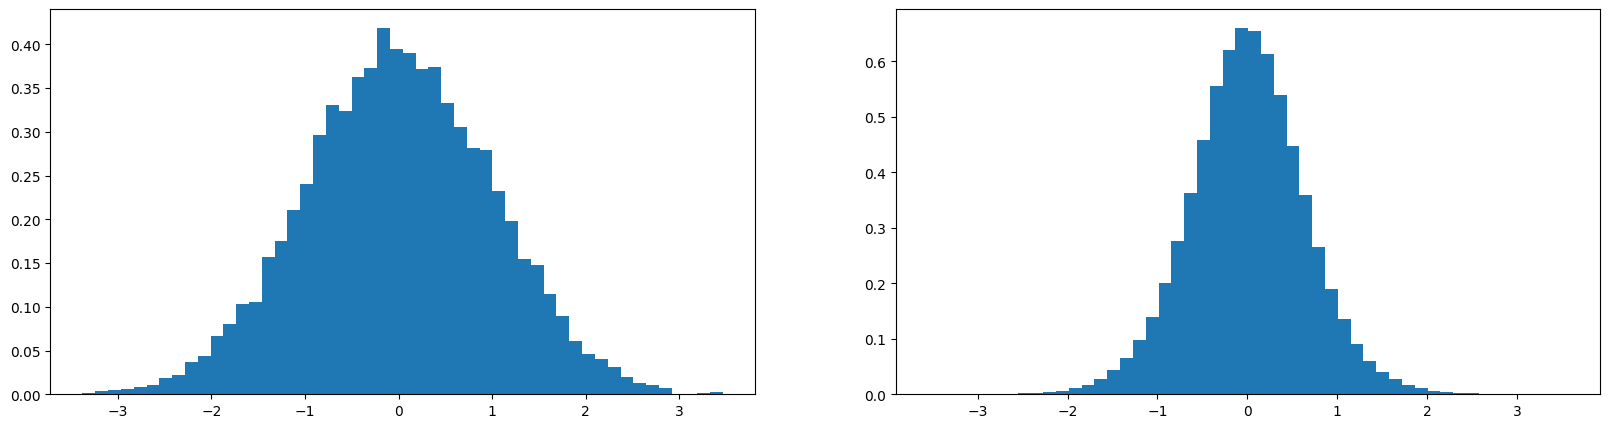

In [98]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y=x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
_ = plt.hist(y.view(-1).tolist(), 50, density=True);

the input is just a guassian, mean 0 and std of 1

the std of y has increased to three

```
tensor(0.0124) tensor(0.9947) <- input
tensor(-0.0070) tensor(3.1710) <- output
```

the output guassian has now expanded. 

we want most of the nn to have roughlt similar activations. so the question is, how do we scale the outputs to preserve the gaussian output?

lets multiply the weights by five `w = torch.randn(10, 200) * 5`:

```
tensor(-0.0124) tensor(1.0053)
tensor(0.0279) tensor(15.9336)
```

lets multiply the weights by five `w = torch.randn(10, 200) * 0.2`:

```
tensor(0.0022) tensor(0.9950)
tensor(0.0012) tensor(0.6430)
```

how do we choose the number by which to scale the weights? for a simple linear layer, divide by a square root of fan in. when you do that, when you have a roughlt guassian input, out of this layer you will have a roughly gaussian output

however, with non linearities, you need to compensate for the discarded part of the distribution, so you also need a gain (look into torch.nn.init). basically the formula for the scaling factor is gain/sqrt(fanin)

so the initalization becomes:

```
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3 * (n_embd * block_size)**-0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```

another way of normalizing the outputs of the layers is batchnorm. since we want hpreact to be roughy gaussian (not to big to avoide the dead space and not to small to avoid the linear part of tanh, which makes it inactive), we can simply take the pre activations for the entire batch and normalize them.

however, we only want the preactivations to be normal gaussian at initialization. we want the neural net to be able to adjust the distribution as it sees fit, during backprop. so we include scale and shift parameters:
```
bngain = torch.ones(n_hidden)
bnbias = torch.zeros(n_hidden)
```

the benefit of batchnorm is that for huge neural nets with many layers, settting the right innit scaling factors becomes intractable. you cannot set everything by hand. but with explicit form of normalization, batch norm, this will be done automatically. it is common to include batchnorm after layers with mutilipcations, such as linear or conv, to control the scale of activations without manual mathematics.

in the following line in the training loop
`hpreact = embcat @ W1 + b1 # hidden layer pre-activation` 
adding the bias here is not wasteful, because the bias is removed during batchnorm and added back as the learned bias

summary of bn:

we are using bn to control the statistics of activations in n

common to sprinkle across the net affter layers wsith muls, like linear or cnn

bnin terlly has params for agin anf bias, trained with badkporp

it als has buffers, not trained, for running stats

bn momentum:

with small batch sizes, the stats might cvhange significantly from iteration to iteration. since the value is chaning aournd a lot, you dont want to take too much from any particular batch. instead, you want to have a large smooting, so the momentum should be kept to low. with large batch sizes, it might be safe to keep the momentum relativlely high.





Batch Normalization: Benefits and Drawbacks
Unexpected Stability at a Cost
1. Batch normalization provides stability in neural networks, but at a significant cost.
This cost involves a fundamental change in how neural networks process data.
Traditional Neural Network Processing
1. Originally, neural networks processed single examples deterministically.
Batches were later introduced for training efficiency, but examples were still processed independently.
The Batch Normalization Paradigm Shift
1. Batch normalization couples examples within a batch mathematically.
This coupling occurs in both forward and backward passes of the neural network.
Impact on Network Activations
Hidden state activations (H) and logits for any input example now depend on:
The input example itself
All other examples in the batch
This leads to subtle changes or "jittering" in activations based on batch composition.
Unexpected Benefits
This "jittering" effect, initially seeming like a bug, turns out to be beneficial.
It acts as a regularizer for the neural network.
Regularization Mechanism
The process effectively "pads out" input examples.
Introduces entropy into the system.
Acts as a form of data augmentation.
Makes it harder for the neural network to overfit specific examples.
Challenges in Removing Batch Normalization
The regularization effect has made it difficult to eliminate batch normalization.
No one likes the property of mathematically coupled examples in a batch.
It can lead to strange results and bugs.
Alternative Normalization Techniques
Efforts to deprecate batch normalization in favor of other techniques that don't couple batch examples:
Layer normalization
Instance normalization
Group normalization

In [96]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = x @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.102678060531616


In [ ]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) * (fan_in)**-0.5
        self.bias = torch.randn((fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# batch norm
# we are using batch norm to control the statistics of the activation in the nn. 
# bn is usually applied after layers with multiplications, such as FC linear or CNN layers.
# bn has params for gain and bias, which are learnable parameters that scale and shift the output of the batch norm.
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

In [ ]:
# visualize historgams for the forward pass
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decode(i) for i in out)) # decode and print the generated word